In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
#from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

###########################################################    
# Training
nclouds = 50000
npoints = 100

# The point clouds
means = torch.rand(nclouds)
covs = torch.rand(nclouds)
normal = torch.randn(nclouds, npoints, 1)

for i in range(nclouds):
    normal[i, :, 0] = normal[i, :, 0]*covs[i] + means[i]
    normal[i, :, 0] %= 1

uniform = torch.rand(nclouds, npoints, 1)

trainset = torch.cat((normal, uniform))

# Function to calculate Q
R=0.1
def charfun(x,y, R):
    if min(abs(x-y), 1 - abs(x-y)) <= R:
        return 1
    return 0
labels = []
for x in trainset.view(-1,npoints).detach().numpy():
    labels.append(1/(len(x)**2) * sum(charfun(k, j, R) for k in x for j in x))

# Labels
labels = torch.tensor(labels).view(-1,1)

# Dataset
dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                          shuffle=True, num_workers=2, drop_last=True)

#########################################################
# Testing clouds

ncloudstest = 100#1000
npointstest = 100

# The point clouds
normaltest = torch.randn(ncloudstest, npointstest, 1)
uniformtest = torch.rand(ncloudstest, npointstest, 1)

means = torch.rand(ncloudstest)
covs = torch.rand(ncloudstest)

for i in range(ncloudstest):
    normaltest[i, :, 0] = normaltest[i, :, 0]*covs[i] + means[i]
    normaltest[i, :, 0] %= 1


testset = torch.cat((normaltest, uniformtest))

labels_test = []
for x in testset.view(-1,npoints).detach().numpy():
    labels_test.append(1/(len(x)**2) * sum(charfun(k, j, R) for k in x for j in x))

# Labels
testlabels = torch.tensor(labels_test).view(-1,1)
test=testset

# Dataset
testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last=True)

In [2]:
class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(k)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, train = True):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        
        
        # I'm not sure if it works better with or without RELU??
        if self.training:
            #x = F.relu(self.bn6(self.dropout(x) * 0.7))
            x = self.bn6(self.dropout(x) * 0.7)
        else:
            #x = F.relu(self.bn6(x))
            x = self.bn6(x)
        return x

In [3]:
############################################################
net = PointNetCls(k=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nepochs = 50

train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    epoch_train_acc = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.783
[1,   200] loss: 0.602
[1,   300] loss: 0.464
[1,   400] loss: 0.345
[1,   500] loss: 0.266
[1,   600] loss: 0.199
[1,   700] loss: 0.144
[1,   800] loss: 0.098
[1,   900] loss: 0.073
[1,  1000] loss: 0.056
[1,  1100] loss: 0.037
[1,  1200] loss: 0.027
[1,  1300] loss: 0.020
[1,  1400] loss: 0.014
[1,  1500] loss: 0.013
[2,   100] loss: 0.010
[2,   200] loss: 0.009
[2,   300] loss: 0.009
[2,   400] loss: 0.010
[2,   500] loss: 0.009
[2,   600] loss: 0.010
[2,   700] loss: 0.009
[2,   800] loss: 0.010
[2,   900] loss: 0.007
[2,  1000] loss: 0.008
[2,  1100] loss: 0.008
[2,  1200] loss: 0.009
[2,  1300] loss: 0.007
[2,  1400] loss: 0.009
[2,  1500] loss: 0.007
[3,   100] loss: 0.008
[3,   200] loss: 0.009
[3,   300] loss: 0.008
[3,   400] loss: 0.007
[3,   500] loss: 0.008
[3,   600] loss: 0.009
[3,   700] loss: 0.008
[3,   800] loss: 0.008
[3,   900] loss: 0.009
[3,  1000] loss: 0.007
[3,  1100] loss: 0.008
[3,  1200] loss: 0.008
[3,  1300] loss: 0.010
[3,  1400] 

[24,   300] loss: 0.009
[24,   400] loss: 0.009
[24,   500] loss: 0.008
[24,   600] loss: 0.008
[24,   700] loss: 0.008
[24,   800] loss: 0.009
[24,   900] loss: 0.009
[24,  1000] loss: 0.009
[24,  1100] loss: 0.007
[24,  1200] loss: 0.008
[24,  1300] loss: 0.007
[24,  1400] loss: 0.008
[24,  1500] loss: 0.008
[25,   100] loss: 0.009
[25,   200] loss: 0.008
[25,   300] loss: 0.008
[25,   400] loss: 0.009
[25,   500] loss: 0.008
[25,   600] loss: 0.008
[25,   700] loss: 0.009
[25,   800] loss: 0.007
[25,   900] loss: 0.009
[25,  1000] loss: 0.009
[25,  1100] loss: 0.007
[25,  1200] loss: 0.009
[25,  1300] loss: 0.008
[25,  1400] loss: 0.008
[25,  1500] loss: 0.009
[26,   100] loss: 0.008
[26,   200] loss: 0.007
[26,   300] loss: 0.008
[26,   400] loss: 0.008
[26,   500] loss: 0.008
[26,   600] loss: 0.008
[26,   700] loss: 0.008
[26,   800] loss: 0.008
[26,   900] loss: 0.007
[26,  1000] loss: 0.008
[26,  1100] loss: 0.008
[26,  1200] loss: 0.008
[26,  1300] loss: 0.008
[26,  1400] loss

[46,  1500] loss: 0.008
[47,   100] loss: 0.009
[47,   200] loss: 0.008
[47,   300] loss: 0.008
[47,   400] loss: 0.007
[47,   500] loss: 0.009
[47,   600] loss: 0.007
[47,   700] loss: 0.008
[47,   800] loss: 0.007
[47,   900] loss: 0.007
[47,  1000] loss: 0.008
[47,  1100] loss: 0.008
[47,  1200] loss: 0.009
[47,  1300] loss: 0.009
[47,  1400] loss: 0.008
[47,  1500] loss: 0.008
[48,   100] loss: 0.008
[48,   200] loss: 0.008
[48,   300] loss: 0.009
[48,   400] loss: 0.008
[48,   500] loss: 0.009
[48,   600] loss: 0.008
[48,   700] loss: 0.008
[48,   800] loss: 0.008
[48,   900] loss: 0.008
[48,  1000] loss: 0.009
[48,  1100] loss: 0.007
[48,  1200] loss: 0.008
[48,  1300] loss: 0.008
[48,  1400] loss: 0.009
[48,  1500] loss: 0.008
[49,   100] loss: 0.008
[49,   200] loss: 0.007
[49,   300] loss: 0.008
[49,   400] loss: 0.008
[49,   500] loss: 0.008
[49,   600] loss: 0.008
[49,   700] loss: 0.009
[49,   800] loss: 0.008
[49,   900] loss: 0.007
[49,  1000] loss: 0.008
[49,  1100] loss

In [4]:
# Creates more test data - do not have to run

ncloudstest = 5000
npointstest = 100

# The point clouds
normaltest = torch.randn(ncloudstest, npointstest, 1)
uniformtest = torch.rand(ncloudstest, npointstest, 1)
R=0.1
means = torch.rand(ncloudstest)
covs = torch.rand(ncloudstest) #* 0.2

for i in range(ncloudstest):
    normaltest[i, :, 0] = normaltest[i, :, 0]*covs[i] + means[i]
    normaltest[i, :, 0] %= 1


testset = torch.cat((normaltest, uniformtest))

labels_test = []
for x in testset.view(-1,npoints).detach().numpy():
    labels_test.append(1/(len(x)**2) * sum(charfun(k, j, R) for k in x for j in x))

testlabels = torch.tensor(labels_test).view(-1,1)
# Labels
test=testset

testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last=True)

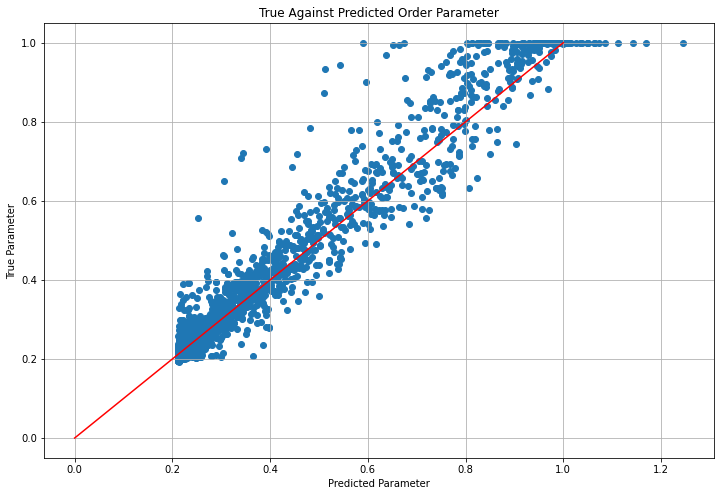

In [5]:
#Set network to evaluate mode
net.eval()

outputs = net(test)
x = outputs.detach().numpy()
y = labels_test

# plot the data
plt.figure(figsize=(12,8))
plt.scatter(x,y)
plt.plot(np.linspace(0, 1, 10), np.power(np.linspace(0, 1, 10), 1), color = 'r', label = 'y = x')
plt.grid()
plt.title("True Against Predicted Order Parameter")
plt.ylabel("True Parameter")
plt.xlabel("Predicted Parameter")
plt.show()